In [1]:
!pip install inflection

In [2]:
!pip install ydata_profiling

In [3]:
!pip install pandas_profiling

In [4]:
!pip install pandasql

In [5]:
!pip install python-dateutil

In [6]:
!pip install boruta

In [7]:
!pip install category-encoders

In [8]:
!pip install XGBoost

## i. O DESAFIO

*   De posse de um dataset contendo informações sobre diversos modelos de carros com seus respectivos preços de venda, tomou-se a decisão de aplicar um modelo de machine learning capaz de realizar a **previsão** de preço de novas entradas na base de dados.

*   De posse da solução, times de negócio podem simular com maior clareza quais os fatores que mais influenciam no preço de venda, tomando vantagem nos negócios a partir de soluções adotadas a partir de dados (Data Driven)

## ii. QUESTÕES DE NEGÓCIO

*   Ao término da aplicação do modelo, é esperado um relatório contendo respostas e curso de ação para as seguintes perguntas:

    1.  Quais as características(features) que mais influenciam a alteração do preço do veículo ?
    
    2.  Quais as premissas tomadas ao longo do processo de tratamento, análise de dados e feature engineering?

    3.  Qual a performance do modelo aplicado e como expressar-los à times de negócio?

    4.  Como colocar o modelo em produção?
    
    5.  Quais são possíveis rotas para a melhoria contínua do modelo?



# 0.0 IMPORTS, FUNÇÕES E DATA LOAD

## 0.1 Imports

In [9]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import xgboost      as xgb
import math
import ipywidgets
import inflection
import warnings
import os

from matplotlib         import pyplot as plt
from collections        import Counter
from ydata_profiling    import ProfileReport
from pandasql           import sqldf
from dateutil           import parser as date_parser
from boruta             import BorutaPy

from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.dummy              import DummyRegressor
from sklearn.ensemble           import ExtraTreesClassifier,RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss, mean_absolute_error, mean_squared_error

from imblearn.ensemble          import BalancedRandomForestClassifier
from imblearn.pipeline          import Pipeline
from imblearn.combine           import SMOTEENN
from imblearn.under_sampling    import EditedNearestNeighbours

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Funções Auxiliares

In [10]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

def mean_absolute_percentage_error(y , yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])


def cross_validation(model_name, model, X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)

    mae_list = []
    mape_list = []
    rmse_list = []

    for idx, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        print(f'Fold k-{idx}')
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        #model
        m = model.fit(X_train, y_train)

        #prediction
        yhat = m.predict(X_test)

        #analysis
        m_result = ml_error(model_name, y_test, yhat)

        #store each performance of kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name' : model_name,
                          'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                          'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                          'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [11]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Database load

In [12]:
df0 = pd.read_csv('datasets/car_prices.csv')
df0.sample(5)

year        make   model        trim   body transmission                vin state  condition  odometer  color interior                                 seller      mmr  sellingprice                                 saledate
11681   2010    Cadillac     SRX        Base    SUV    automatic  3gyfngey9as569260    mo       39.0   80125.0  white     gray  corporate america family credit union  13350.0       14000.0  Wed Dec 31 2014 10:30:00 GMT-0800 (PST)
237306  2013   Chevrolet   Cruze         1LT  Sedan    automatic  1g1pc5sb9d7207350    or       37.0   34244.0  beige    black                       avis corporation  11600.0       11500.0  Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
470841  2007      Nissan  Murano          SL    suv    automatic  jn8az08t37w502540    ga       25.0  118528.0  white    beige              atlanta dealer trades inc   7150.0        7500.0  Thu May 28 2015 03:00:00 GMT-0700 (PDT)
509244  2012  Mitsubishi  Galant          ES  sedan    automatic  4a32b3ff1ce014428    fl       31.0   36689.0  black    beige            wells fargo dealer services   9450.0        7700.0  Tue Jun 09 2015 02:30:00 GMT-0700 (PDT)
92885   2006        ford    f150  4x4 ex xlt    NaN    automatic  1ftrx14w76fb37482    wa       34.0   94118.0  brown      tan          crossborder vehicle sales ltd  10150.0       11000.0  Wed Jan 07 2015 12:30:00 GMT-0800 (PST)

In [13]:
#df0 = pd.read_csv('/home/valquiriaam/repos/case_dasa/datasets/car_prices.csv')
#df0.sample(5)

In [14]:
print(f'Number of Rows: {df0.shape[0]}')
print(f'Number of Columns: {df0.shape[1]}')

Number of Rows: 558837
Number of Columns: 16


# 1.0 DESCRIÇÃO DOS DADOS

In [15]:
df1 = df0.copy()

In [16]:
df1.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

In [17]:
cols_old = [ 'year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

In [18]:
#Reordenando Colunas
cols = ['vin', 'year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'saledate',
       'mmr', 'sellingprice']

df1 = df1[cols]
df1.sample()

vin  year   make   model  trim   body transmission state  condition  odometer color interior                   seller                                 saledate     mmr  sellingprice
331345  2d4fv47t08h221305  2008  Dodge  Magnum  Base  Wagon    automatic    tx        2.0   57858.0  blue     gray  lithia toyota of odessa  Fri Feb 20 2015 10:00:00 GMT-0800 (PST)  6550.0        6100.0

## 1.1 Overview Geral

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           558833 non-null  object 
 1   year          558837 non-null  int64  
 2   make          548536 non-null  object 
 3   model         548438 non-null  object 
 4   trim          548186 non-null  object 
 5   body          545642 non-null  object 
 6   transmission  493485 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  saledate      558825 non-null  object 
 14  mmr           558799 non-null  float64
 15  sellingprice  558825 non-null  float64
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [20]:
df1_profile = ProfileReport(df1, title='Profile Report')
df1_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*   vin: Código de identificação de veículo

*   year: Ano de Fabricação do Veículo

*   make: Montadora Fabricante do Veículo

*   model: Modelo do Veículo

*   trim: Versão de acabamento do véiculo

*   body: Categoria de carroceria do veículo

*   transmission: Tipo de Transmissão

*   state: Estado onde o veículo foi fabricado

*   condition: Pontuação que expressa a condição do veículo (Valores de 0 a 50)

*   odometer: Medição do Hodômetro indicado pelo veículo(Distância Percorrida)

*   color: Cor do Véiculo

*   interior: Acabamento Interno

*   seller: Vendedor/Revendedora

*   saledate: Data de venda

*   mmr: (Manheim Market Report) - Valor de venda estimada para o veículo, estabelecido pela rede de casas de leilão Manheim, presente em todos os Estados dos EUA.

*   sellingprice: Preço Vendido

## 1.2 Tratamento de Dados Faltantes/Inconsistentes

### 1.2.1 Coluna 'vin' (Reorganização do dataset)

In [21]:
#Coluna vin

df1[df1['vin'] == 'automatic'].sample(5)

vin  year        make  model                    trim         body transmission              state  condition  odometer  color interior seller saledate  mmr  sellingprice
497011  automatic  2015  Volkswagen  Jetta  SE PZEV w/Connectivity  Navitgation        sedan  3vwd17aj5fm221322        NaN      48.0  18384   silver  black    13500  NaN       13550.0
554710  automatic  2015  Volkswagen  Jetta  SE PZEV w/Connectivity  Navitgation        sedan  3vwd17aj2fm261566        NaN      48.0   5001     blue   gray    13600  NaN       13400.0
529622  automatic  2015  Volkswagen  Jetta  SE PZEV w/Connectivity  Navitgation        sedan  3vwd17aj5fm225953        NaN      41.0  18561    black  black    13100  NaN       13200.0
529013  automatic  2015  Volkswagen  Jetta  SE PZEV w/Connectivity  Navitgation        sedan  3vwd17aj4fm236636        NaN       5.0   5705        —  black    15250  NaN       13400.0
497008  automatic  2015  Volkswagen  Jetta  SE PZEV w/Connectivity  Navitgation        sedan  3vwd17aj5fm273601        NaN      28.0    339    black  black    12900  NaN       14300.0

In [22]:
df1['body'] = df1.apply(lambda x: 'sedan' if x['vin'] == 'automatic' else
                                             x['body'], axis=1)

df1['transmission'] = df1.apply(lambda x: 'automatic' if x['vin'] == 'automatic' else
                                                         x['transmission'], axis=1)

df1['condition'] = df1.apply(lambda x: x['odometer'] if x['vin'] == 'automatic' else
                                                        x['condition'], axis=1)

df1['odometer'] = df1.apply(lambda x: x['color'] if x['vin'] == 'automatic' else
                                                    x['odometer'], axis=1)

df1['color'] = df1.apply(lambda x: x['interior'] if x['vin'] == 'automatic' else
                                                    x['color'], axis=1)

df1['interior'] = df1.apply(lambda x: x['seller'] if x['vin'] == 'automatic' else
                                                     x['interior'], axis=1)

df1['seller'] = df1.apply(lambda x: '-' if x['vin'] == 'automatic' else
                                           x['seller'], axis=1)

df1['mmr'] = df1.apply(lambda x: x['saledate'] if x['vin'] == 'automatic' else
                                                  x['mmr'], axis=1)

df1['saledate'] =  df1.apply(lambda x: 'Tue Dec 16 2014 12:30:00 GMT-0800 (PST)' if x['vin'] == 'automatic' else
                                                                                    x['saledate'], axis=1)

df1['vin'] =  df1.apply(lambda x: x['state'] if x['vin'] == 'automatic' else
                                                x['vin'], axis=1)

df1['state'] =  df1.apply(lambda x: 'ca' if x['vin'] == x['state'] else
                                            x['state'], axis=1)


In [23]:
df1 = df1.dropna(subset=['vin'])


In [24]:
df1[df1['vin'] == '3vwd17aj4fm201708'].sample()

vin  year        make  model                    trim   body transmission state  condition odometer   color interior seller                                 saledate    mmr  sellingprice
408161  3vwd17aj4fm201708  2015  Volkswagen  Jetta  SE PZEV w/Connectivity  sedan    automatic    ca       46.0     4802  silver     gray      -  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  16500       13200.0

### 1.2.2 Preenchimento dos dados faltantes nas demais colunas

## Observações e premissas adotadas para cada coluna:

*   vin: A Coluna com o indicador de código de identificação do veículo 'vin', apresentava inconsistência para valores observados como 'automatic' no pandas profiling: Tais entradas foram corrigidas, assumindo transmissão como 'automática' e Estado de produção do veículo como 'ca' (Preenchimento por voto de maioria). Valores faltantes (NaN) tiveram suas linhas removidas.

*   make: Entradas com a coluna 'make' faltante (NaN), também apresentaram dados faltantes para demais características do carro (model, body, trim), sendo descartadas pela impossibilidade de ganho de informação

*   model: Entradas faltantes para 'model' foram observados para modelos que não fazem distinção de modelo/acabamento. Valores 'NaN' foram preenchidos com o nome do modelo, colocados inicialmente na coluna 'trim'.

*   trim: Modelos que não tem distinção de acabamento tiveram valores ausentes preenchidos com '-'

*   body: Modelos sem especificação de carroceria foram preenchidos com valor '-'.

*   transmission: Valores faltantes preenchidos como 'automatic', por voto de maioria absoluta no dataset.

*   condition: Os dados faltantes foram preenchidos com o score equivalente a mediana da base de dados encontradas pelo pandas profiling, que é o valor de 31.

*   odometer: Os dados faltantes foram preenchidos com o valor médio de distância percorrida das entradas presentes no dataset, que é o valor de 68320 milhas.

*   color: Dados Faltantes preenchidos com '-'.

*   interior: Dados faltantes preenchidos com '-'.

*   saledate: Linhas com valores faltantes removidas

*   mmr: Linhas com valores faltantes removidas

*   sellingprice:Linhas com valores faltantes removidas

## NOTA: Por observação no pandas profiling e  preenchimento do dado de cada coluna, não foram observados outliers ou dados anormais nas distribuições de cada coluna.

In [25]:
df1 = df1.dropna(subset=['make'])

In [26]:
df1['model'] = df1.apply(lambda x: x['trim'] if pd.isna(x['model']) else
                                                x['model'], axis=1)

df1['trim'] = df1.apply(lambda x: '-' if pd.isna(x['trim']) else
                                         x['trim'], axis=1)

df1['body'] = df1.apply(lambda x: '-' if pd.isna(x['body']) else
                                         x['body'], axis=1)

df1['transmission'] = df1.apply(lambda x: 'automatic' if pd.isna(x['transmission']) else
                                                         x['transmission'], axis=1)

df1['condition'] = df1.apply(lambda x: 31 if pd.isna(x['condition']) else
                                             x['condition'], axis=1)

df1['odometer'] = df1.apply(lambda x: 68320 if pd.isna(x['odometer']) else
                                               x['odometer'], axis=1)

df1['color'] = df1.apply(lambda x: '-' if pd.isna(x['color']) else
                                          x['color'], axis=1)

df1['interior'] = df1.apply(lambda x: '-' if pd.isna(x['interior']) else
                                          x['interior'], axis=1)

In [27]:
df1.drop

df1 = df1.dropna(subset=['saledate', 'mmr', 'sellingprice'])

In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548520 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           548520 non-null  object 
 1   year          548520 non-null  int64  
 2   make          548520 non-null  object 
 3   model         548520 non-null  object 
 4   trim          548520 non-null  object 
 5   body          548520 non-null  object 
 6   transmission  548520 non-null  object 
 7   state         548520 non-null  object 
 8   condition     548520 non-null  float64
 9   odometer      548520 non-null  object 
 10  color         548520 non-null  object 
 11  interior      548520 non-null  object 
 12  seller        548520 non-null  object 
 13  saledate      548520 non-null  object 
 14  mmr           548520 non-null  object 
 15  sellingprice  548520 non-null  float64
dtypes: float64(2), int64(1), object(13)
memory usage: 71.1+ MB


## 1.3 Tipificação dos Dados e Tratamento dos Valores de Data (Coluna 'saledate')

*   A tipagem das colunas 'condition', 'odometer' e 'mmr' serão alteradas para valores numéricos

*   A coluna 'salesdate' (que contém a data de venda do veículo), será desmembrada de forma a permitir maior precisão nas análises envolvendo datas.

In [29]:
df1['condition'] = df1['condition'].astype(np.int64)

df1['odometer'] = df1['odometer']. astype(np.int64)

df1['mmr'] = df1['mmr']. astype(np.float64)

In [30]:
df1['day_of_week'] = df1['saledate'].apply(lambda x: date_parser.parse(x).strftime('%a'))

#'saledate' conversion to datetime
df1['saledate'] = df1['saledate'].apply(lambda x: date_parser.parse(x).strftime('%Y-%m-%d'))
df1['saledate'] = pd.to_datetime(df1['saledate'])

#year_sold
df1['year_sold'] = df1['saledate'].dt.year.astype(np.int64)

#month_sold
df1['month_sold'] = df1['saledate'].dt.month.astype(np.int64)

#day_sold
df1['day_sold'] = df1['saledate'].dt.day.astype(np.int64)

In [31]:
df1.columns

Index(['vin', 'year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'saledate',
       'mmr', 'sellingprice', 'day_of_week', 'year_sold', 'month_sold',
       'day_sold'],
      dtype='object')

In [32]:
df1.drop(columns=['saledate'], axis=1, inplace=True)

In [33]:
#Reordenando Colunas
cols = ['vin', 'year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'year_sold',
       'month_sold', 'day_sold','day_of_week', 'mmr', 'sellingprice']

df1 = df1[cols]
df1.sample(5)

vin  year   make             model    trim       body transmission state  condition  odometer   color interior                                seller  year_sold  month_sold  day_sold day_of_week      mmr  sellingprice
469103  5fnrl5h43cb091449  2012  Honda           Odyssey      EX    minivan    automatic    pa         28     40961    gray     gray  ahfc/honda lease trust/hvt  inc. eot       2015           5        28         Thu  17000.0       17200.0
489422  1ft8w3bt4bea81035  2011   Ford  F-350 Super Duty  Lariat   crew cab    automatic    fl         37     95087  silver    black                      tdaf remarketing       2015           6         2         Tue  30400.0       32600.0
527078  2hgfg12629h505643  2009  Honda             Civic      LX      coupe    automatic    fl         21     95622   black     gray                               gte fcu       2015           6        11         Thu   5775.0        5400.0
444192  2c3cdybt6dh614371  2013  Dodge        Challenger     R/T      Coupe    automatic    ne         37     21125   black    black               eckley auto brokers inc       2015           5        21         Thu  24700.0       27100.0
367791  3fafp37n05r114117  2005   Ford             Focus  ZX5 SE  Hatchback    automatic    tx         35     76666   white     gray                      bmw of arlington       2015           3         5         Thu   2850.0        3300.0

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548520 entries, 0 to 558836
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           548520 non-null  object 
 1   year          548520 non-null  int64  
 2   make          548520 non-null  object 
 3   model         548520 non-null  object 
 4   trim          548520 non-null  object 
 5   body          548520 non-null  object 
 6   transmission  548520 non-null  object 
 7   state         548520 non-null  object 
 8   condition     548520 non-null  int64  
 9   odometer      548520 non-null  int64  
 10  color         548520 non-null  object 
 11  interior      548520 non-null  object 
 12  seller        548520 non-null  object 
 13  year_sold     548520 non-null  int64  
 14  month_sold    548520 non-null  int64  
 15  day_sold      548520 non-null  int64  
 16  day_of_week   548520 non-null  object 
 17  mmr           548520 non-null  float64
 18  sellingpr

# 2.0 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [35]:
df2 = df1.copy()

## 2.1 Validação de Hipóteses

De forma a seguir com a escolha das principais váriaveis a serem utilizadas no modelo de previsão em Machine Learning, testa-se a validade de algumas hipóteses, a saber:

1.  Veículos mais novos (ano de fabricação 2010 ou superior) são vendidos por preços até 10% superior (em média).

2.  Veículos de montadoras não-americanas são vendidos por preços em média 10% superiores.

3.  Veículos maiores (feature 'body') são vendidos por preços em média 15% superiores aos demais.

4.  Veículos com câmbio automatico são vendidos por preços em média 15% superiores.

5.  Veículos com odômetro indicando marca superior a 68.000 milhas são vendidos por preços até 20% mais baratos

6.  O Montante do valor em vendas é até 30% superior no segundo semestre (Meses de 6 a 12)

7.  O Montante do valor em vendas é até 30% superior após o dia 10 dos meses.

8. O Montante do valor em vendas é em média até 20% superior aos finais de semana


### 1.  Veículos mais novos (ano de fabricação 2010 ou superior) são vendidos por preços em média 10% superiores.

*Verdadeiro*: Observa-se um valor médio de venda muito maior para carros com fabricação após 2010

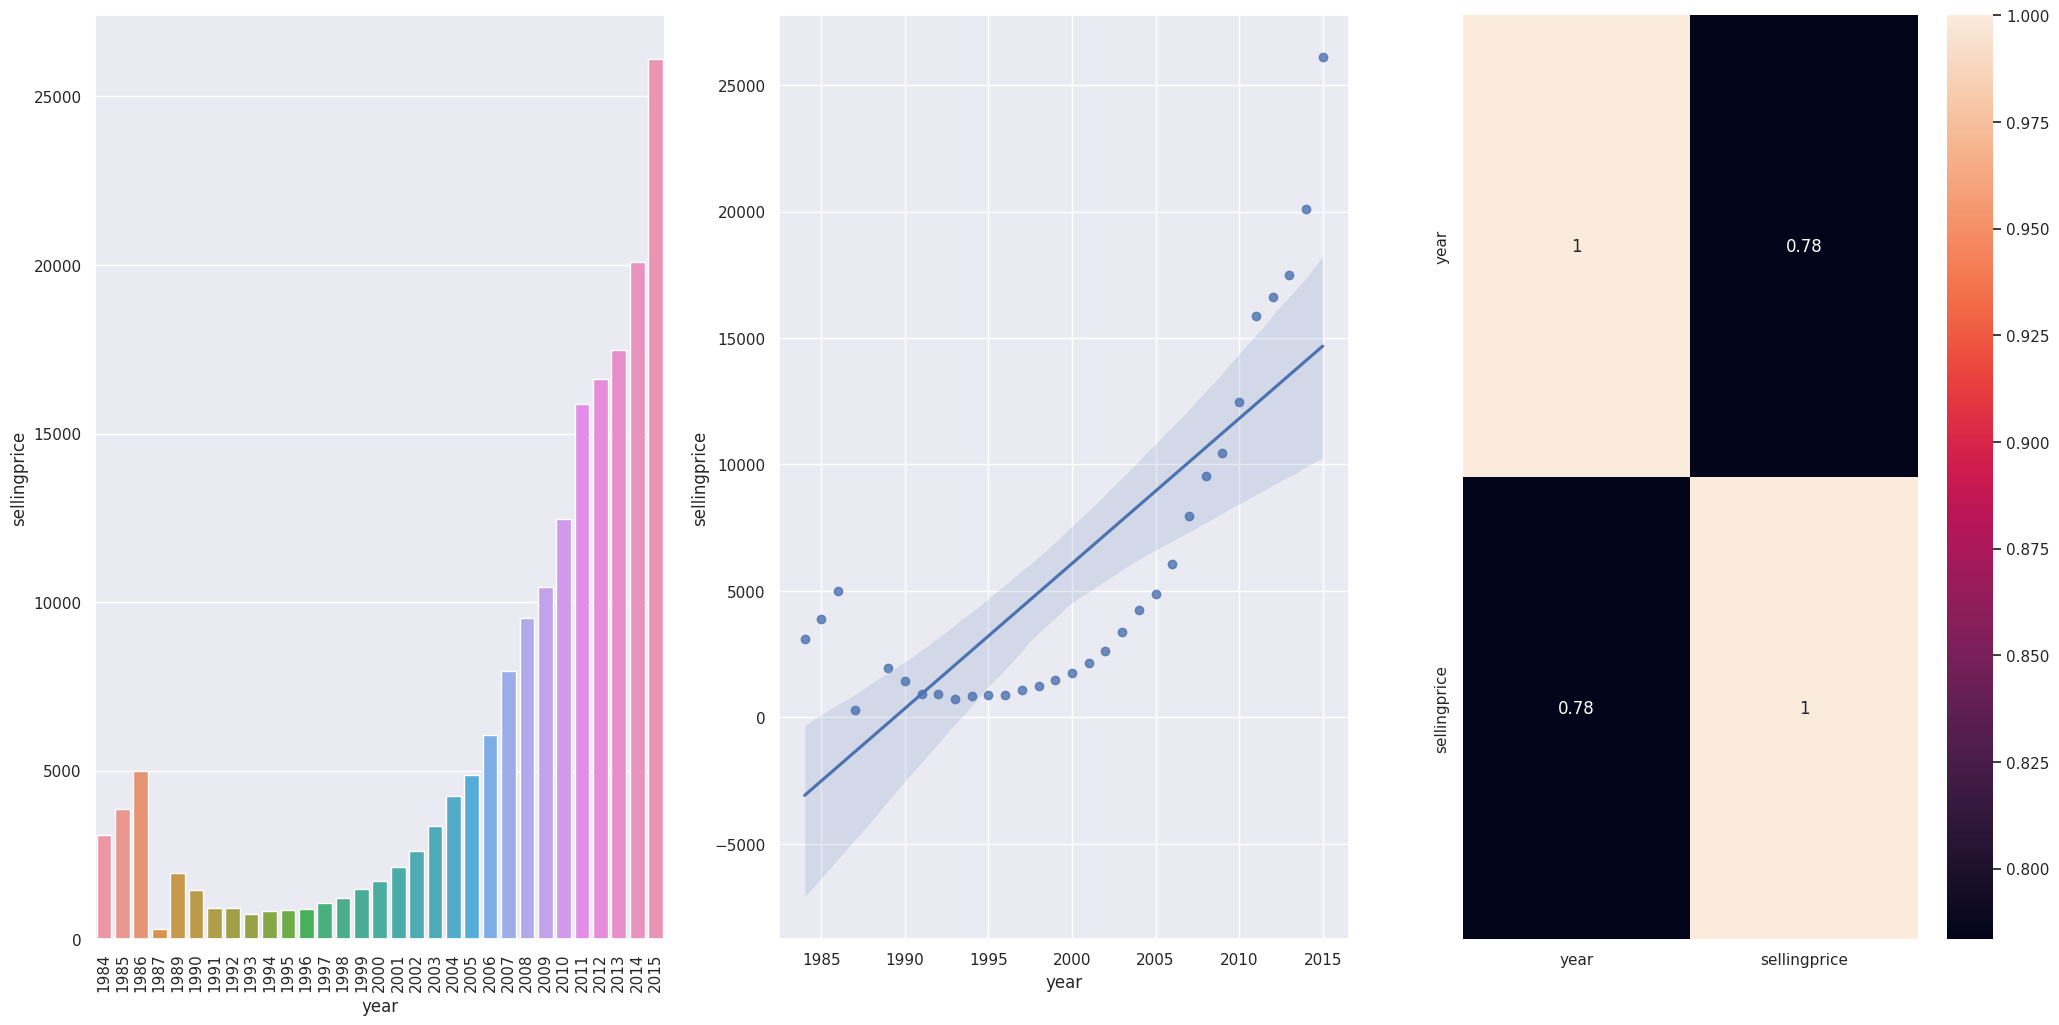

In [36]:
aux = df2[['year', 'sellingprice']].groupby('year').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux, x='year', y='sellingprice');
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(data=aux, x='year', y='sellingprice');

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 2.  Veículos de montadoras não-americanas são vendidos por preços em média 10% inferiores.

_Falso_: Carros de Montadoras americanas possuem valor média muito próxima a de carros estrangeiros (alteração percentual pouco significativa)

**NOTA**: Há a presença de marcas de luxo na database, o que faz com que a montadora tenha sim forte influência na variável alvo

In [37]:
df2['make'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', 'bmw', 'Dodge', 'FIAT',
       'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC', 'mitsubishi', 'Ram',
       'smart', 'chevrolet', 'Bentley', 'chrysler', 'pontiac', 'Pontiac',
       'Saturn', 'Maserati', 'Mercury', 'HUMMER', 'landrover', 'cadillac',
       'land rover', 'mercedes', 'mazda', 'toyota', 'lexus', 'gmc truck',
       'honda', 'nissan', 'porsche', 'Saab', 'Suzuki', 'dodge', 'subaru',
       'Oldsmobile', 'oldsmobile', 'hyundai', 'jeep', 'Isuzu', 'dodge tk',
       'Geo', 'acura', 'volkswagen', 'suzuki', 'kia', 'audi',
       'Rolls-Royce', 'gmc', 'maserati', 'mazda tk', 'mercury', 'buick',
       'hyundai tk', 'mercedes-b', 'vw', 'Daewoo', 'chev truck',
       'ford t

In [38]:
list_usa = ['Chevrolet', 'Ford', 'Buick', 'Cadillac', 'Acura', 'Lexus',
            'Infiniti', 'Lincoln', 'lincoln', 'Dodge', 'Chrysler', 'ford',
            'GMC',  'Ram', 'chevrolet', 'pontiac', 'Pontiac', 'Saturn',
            'Mercury', 'HUMMER', 'cadillac',  'lexus', 'gmc truck',
            'dodge', 'dodge tk', 'Geo', 'acura', 'gmc', 'mercury',
            'buick',  'chev truck', 'ford tk', 'plymouth', 'Plymouth',
            'ford truck', 'Tesla', 'airstream', 'dot',]

aux_df2 = df2.copy()
aux_df2['make_usa'] = aux_df2.apply(lambda x: 'USA' if x['make'] in list_usa
                                                    else 'Other Countries', axis=1)

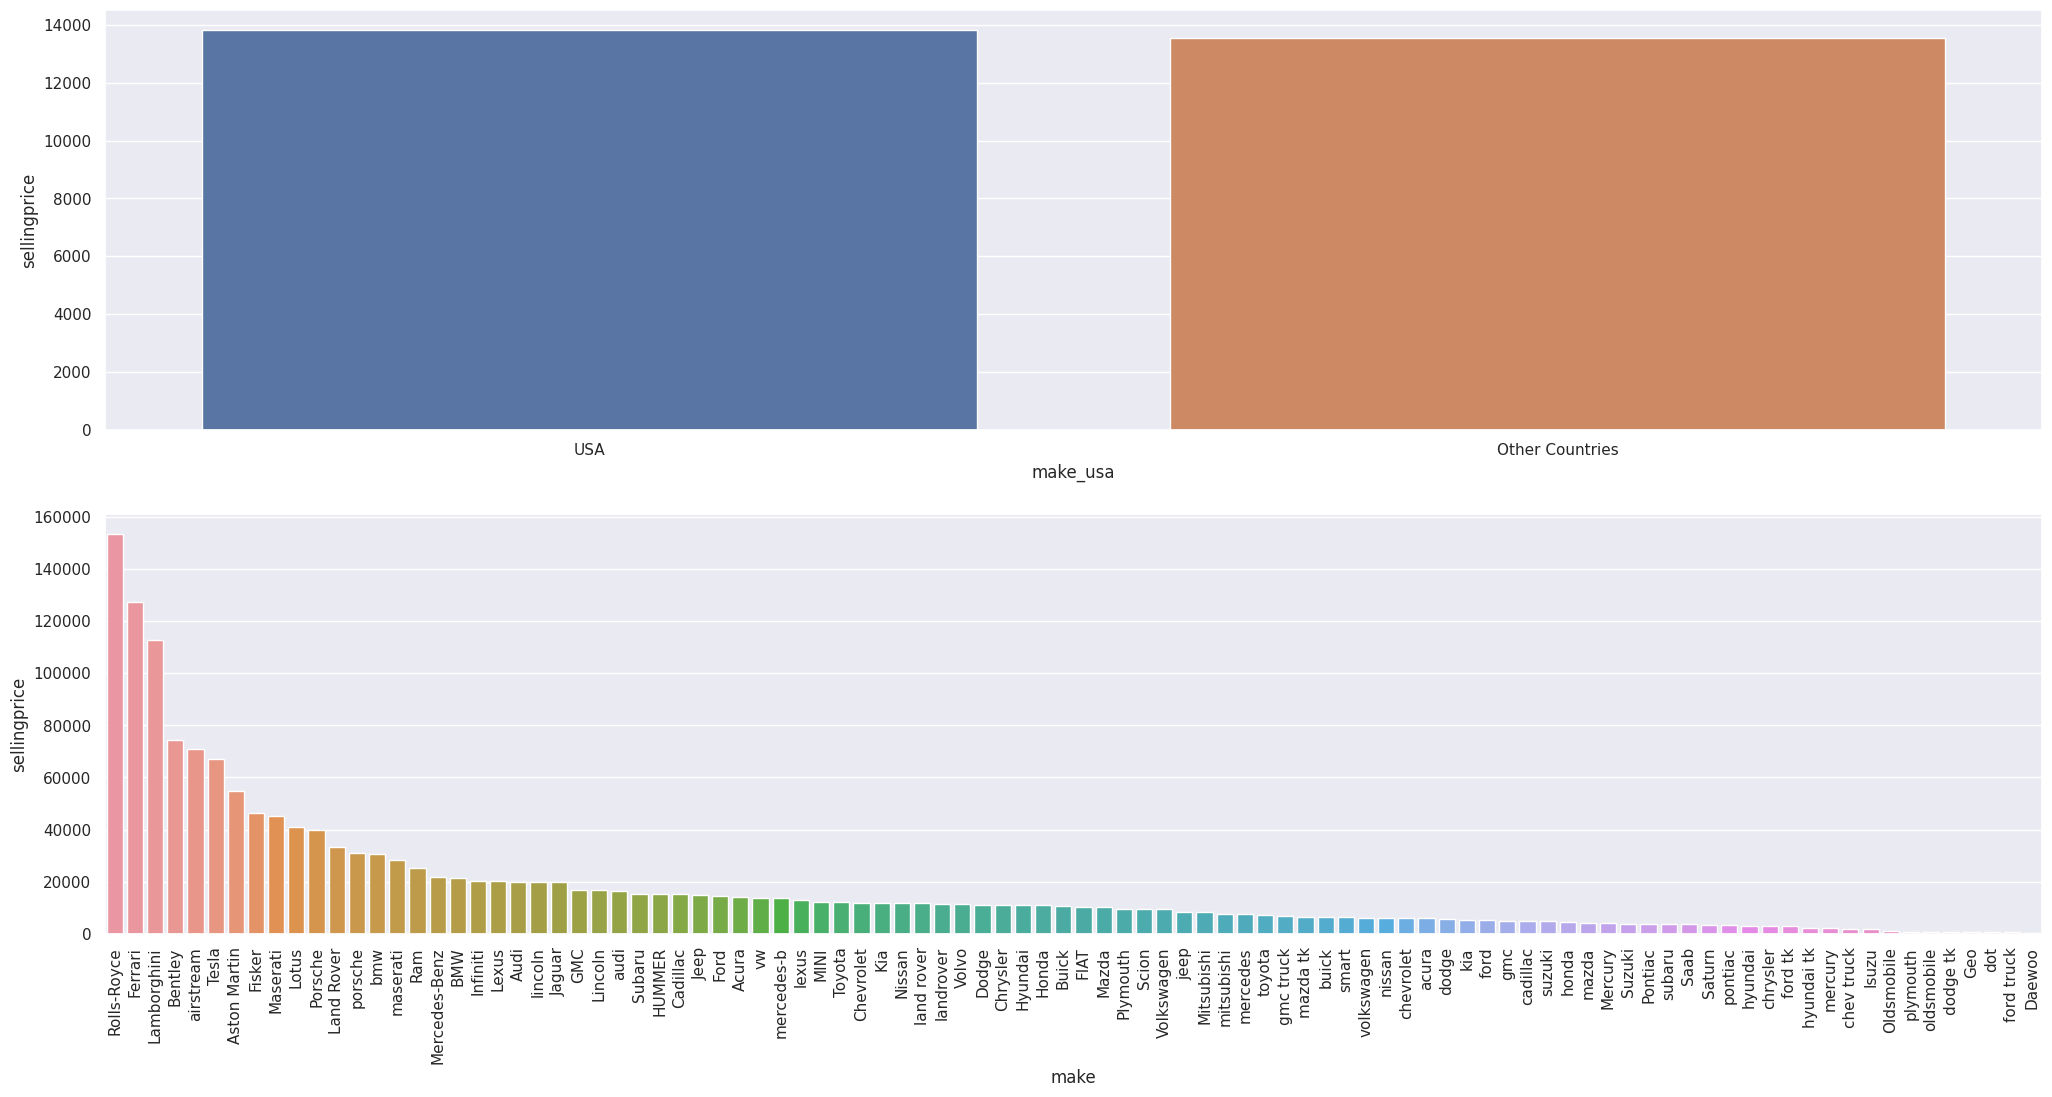

In [39]:
aux = aux_df2[['make_usa', 'sellingprice']].groupby('make_usa').mean().reset_index().sort_values('sellingprice', ascending=False)
aux2 = aux_df2[['make', 'sellingprice']].groupby('make').mean().reset_index().sort_values('sellingprice', ascending=False)

plt.subplot(2,1,1)
sns.barplot(data=aux, x='make_usa', y='sellingprice');

plt.subplot(2,1,2)
sns.barplot(data=aux2, x='make', y='sellingprice');
plt.xticks(rotation=90);

### 3.  Veículos maiores (feature 'body') são vendidos por preços em média 15% superiores aos demais.

_Falso_: Há uma grande quantidade de classes de veículos conversíveis e de duas portas(coupe) cujos preços médios são maiores que a média.

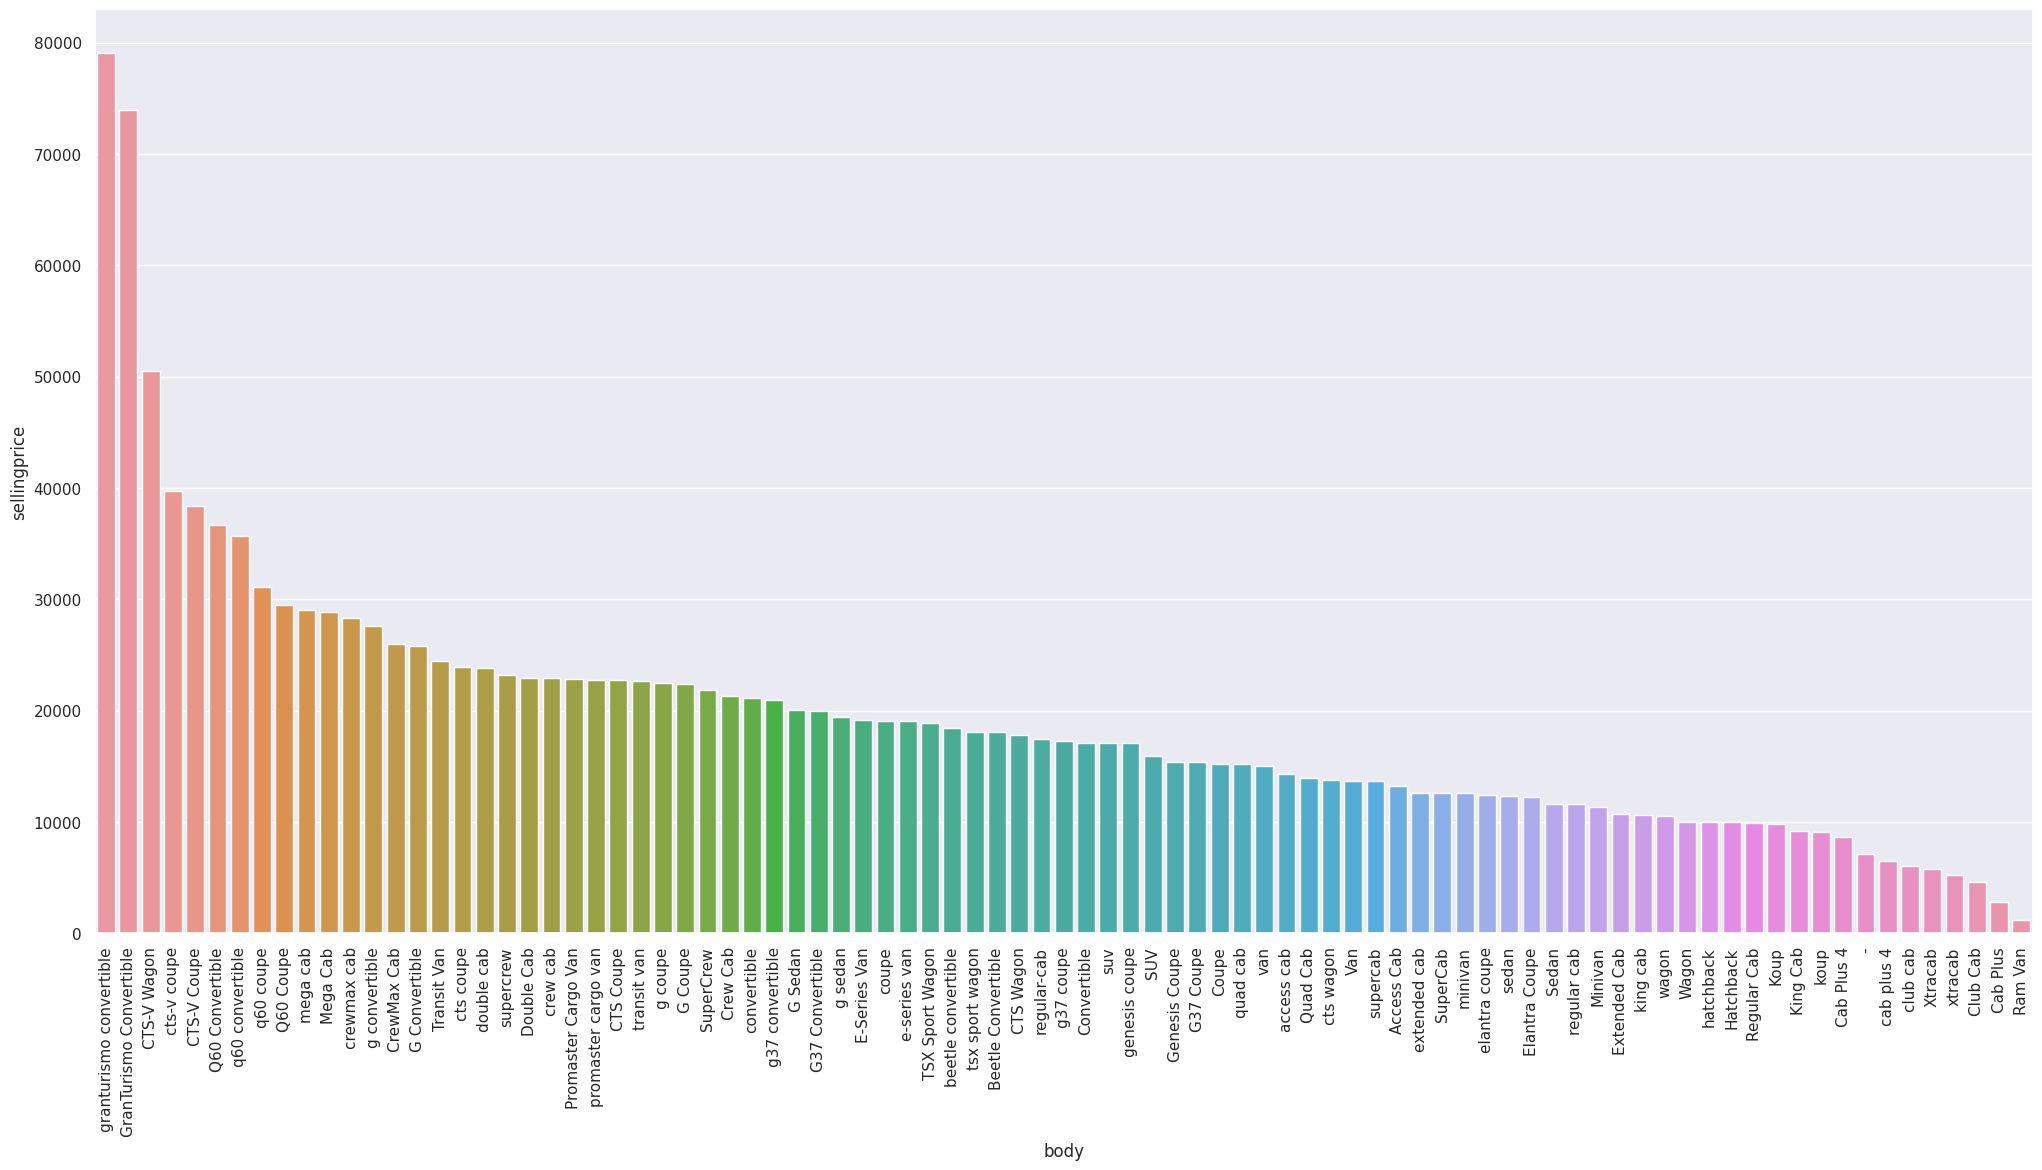

In [40]:
aux = df2[['body', 'sellingprice']].groupby('body').mean().reset_index().sort_values('sellingprice', ascending=False)

sns.barplot(data=aux, x='body', y='sellingprice');
plt.xticks(rotation=90);

### 4. Veículos com câmbio automatico são vendidos por preços em média 15% superiores.

_Verdadeiro_: Veículos com câmbio automático são possuem valor em média até 25% maiores em comparação à veículos com câmbio manual.

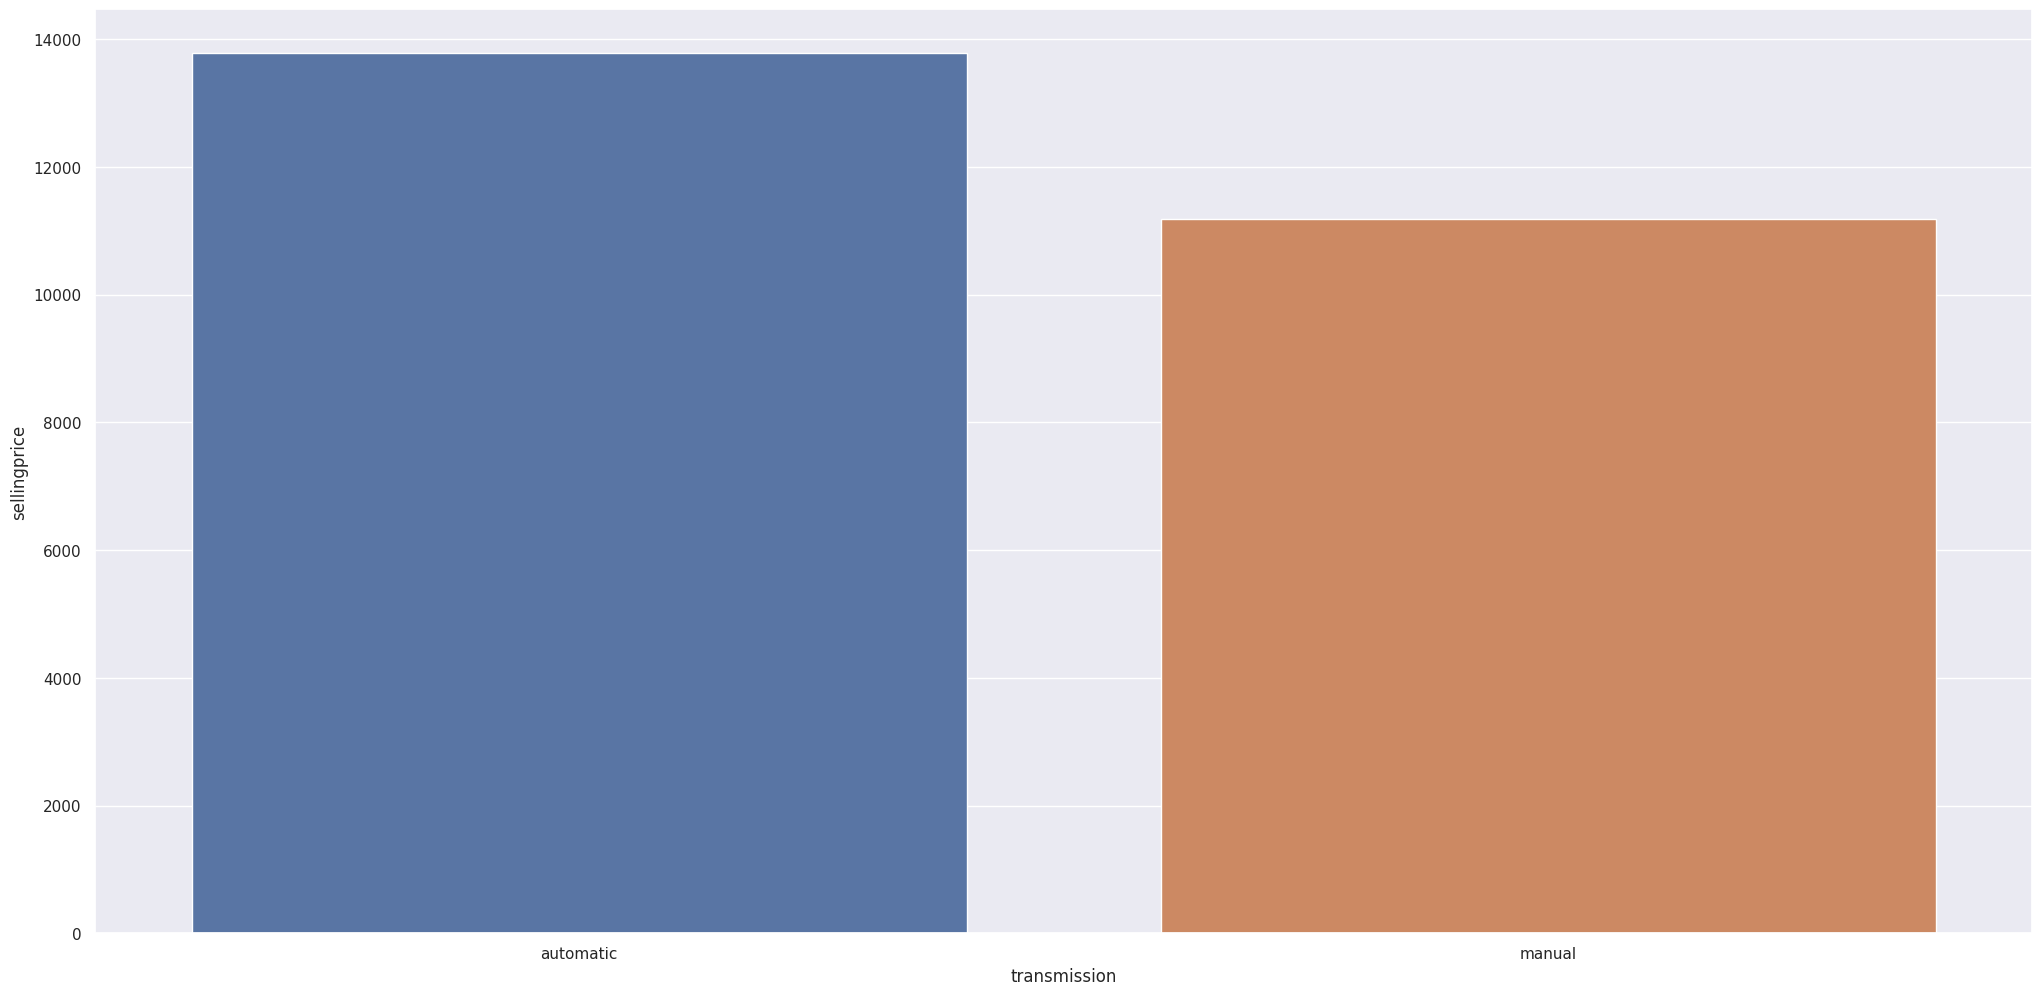

In [41]:
aux = df2[['transmission', 'sellingprice']].groupby('transmission').mean().reset_index().sort_values('sellingprice', ascending=False)

sns.barplot(data=aux, x='transmission', y='sellingprice');

In [42]:
aux.head()

transmission  sellingprice
0    automatic  13779.127879
1       manual  11179.788737

### 5.  Veículos com odômetro indicando marca superior a 68.000 milhas são vendidos por preços até 30% mais baratos em média.

_Verdadeiro_: Há uma correlação muito forte entre a marca indicada no odometro e o preço de venda

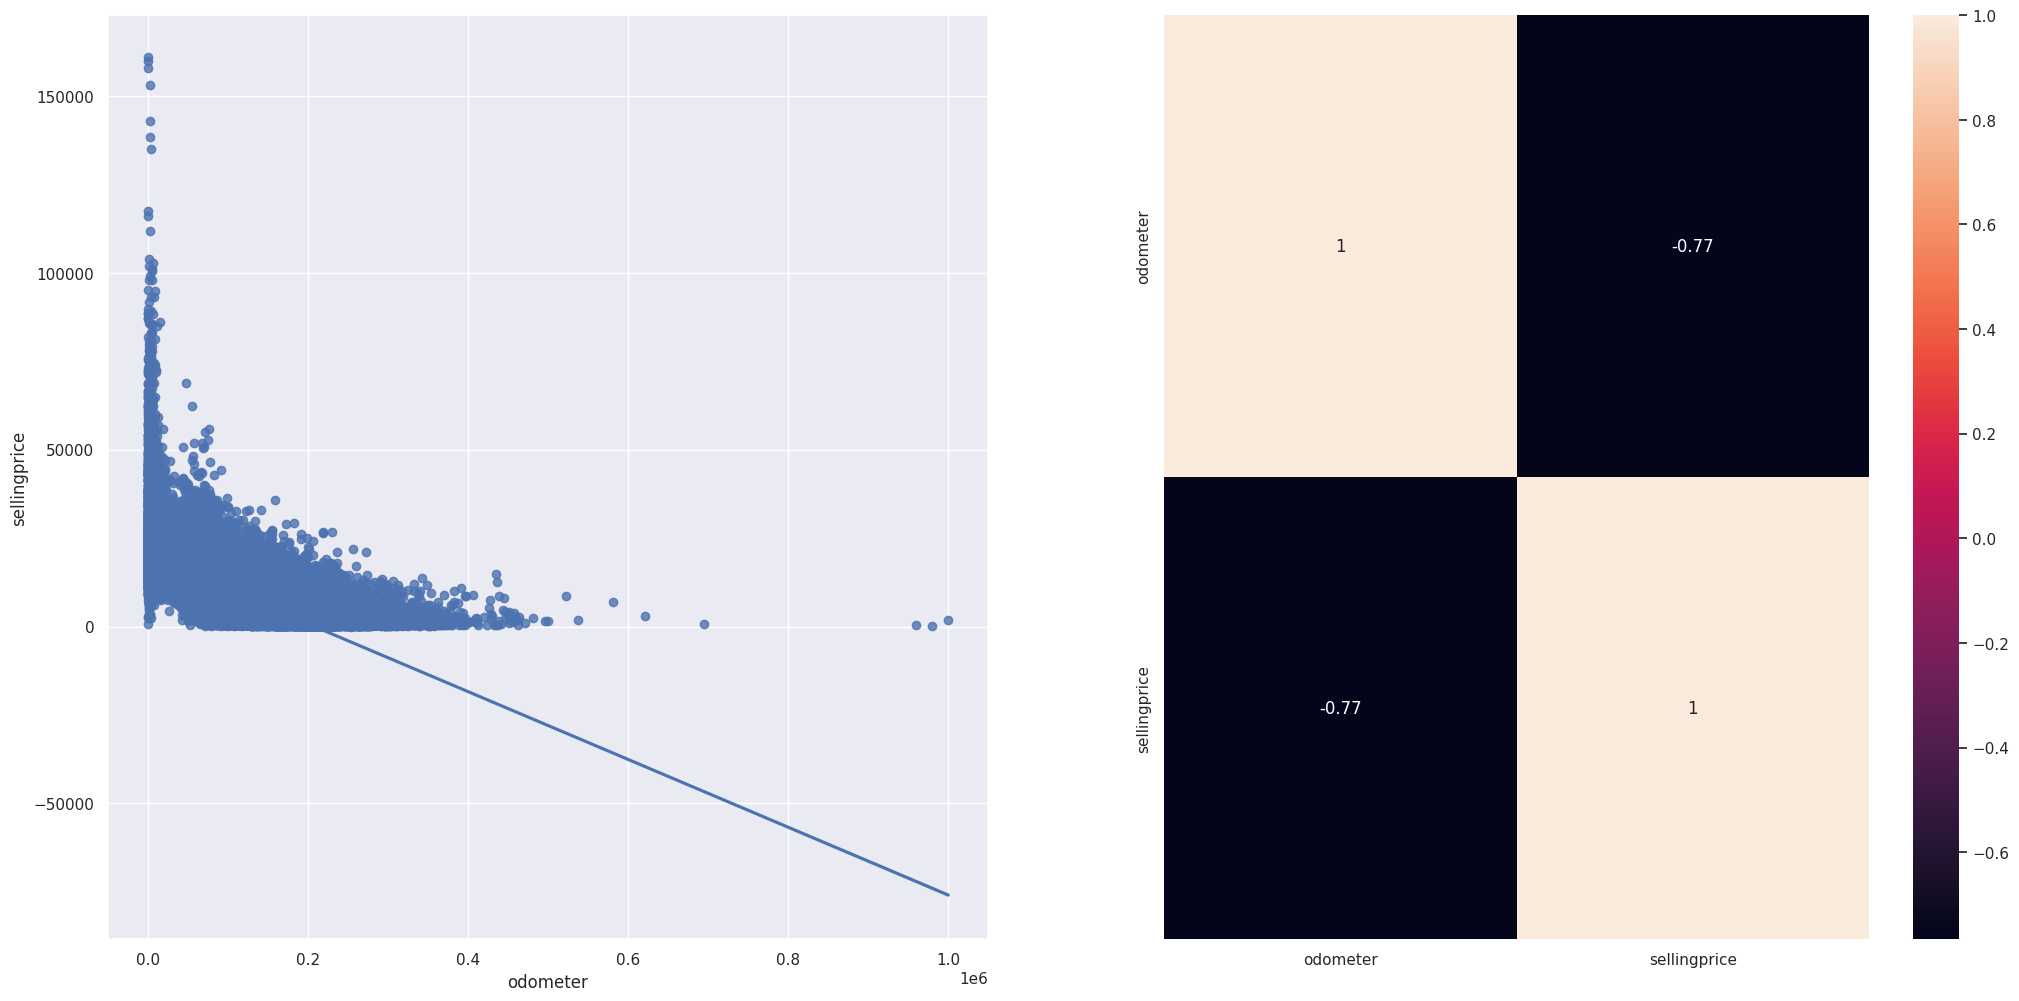

In [43]:
aux = df2[['odometer', 'sellingprice']].groupby('odometer').mean().reset_index()

plt.subplot(1,2,1)
sns.regplot(data=aux, x='odometer', y='sellingprice');

plt.subplot(1,2,2)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 6.  O Montante do valor em vendas é até 30% superior no segundo semestre (Meses de 6 a 12)


Falso -> Há uma disparidade muito grande entre o montante de vendas superior do primeiro semestre em comparação ao segundo.

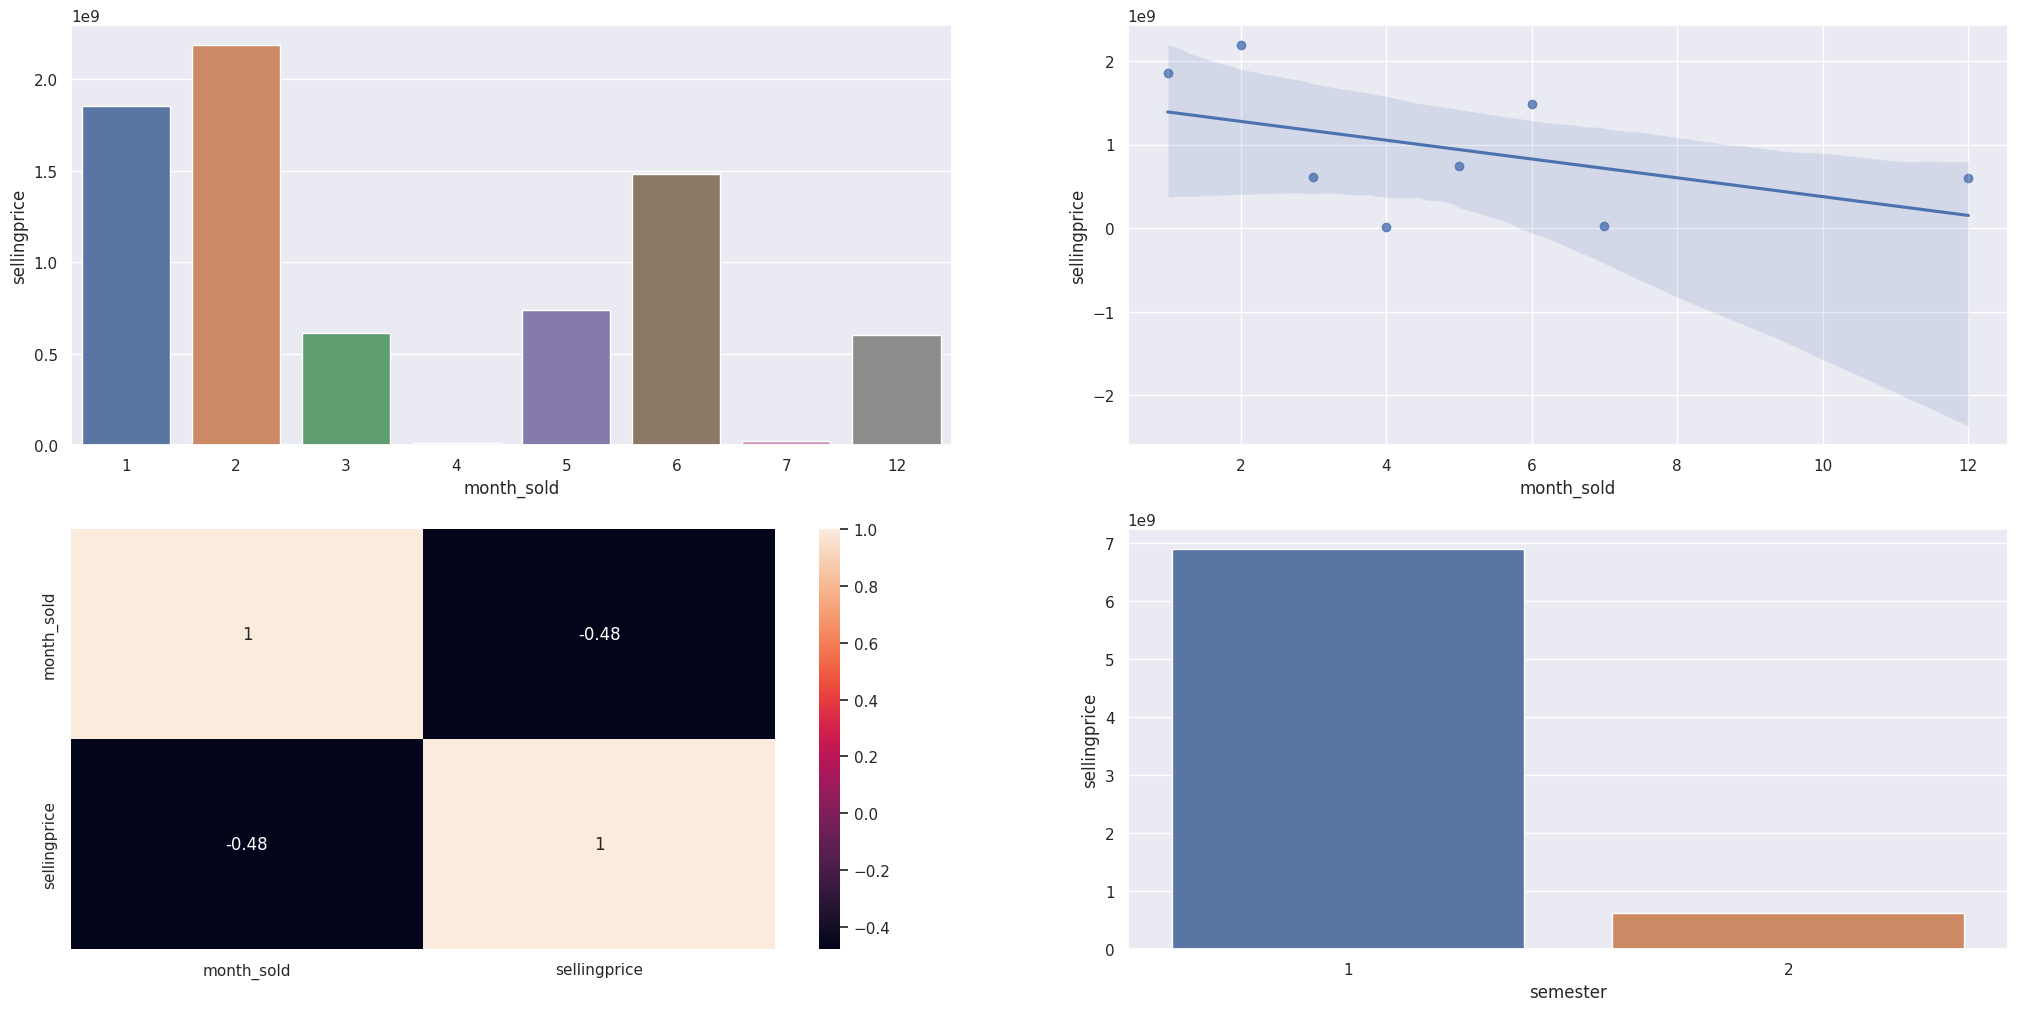

In [44]:
aux2 = df2[['month_sold', 'sellingprice']].groupby('month_sold').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(data=aux2, x='month_sold', y='sellingprice');

plt.subplot(2,2,2)
sns.regplot(data=aux2, x='month_sold', y='sellingprice');

plt.subplot(2,2,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux2['semester'] = aux2['month_sold'].apply(lambda x: '1' if x <= 6 else '2')
aux2 = aux2[['semester', 'sellingprice']].groupby('semester').sum().reset_index()
sns.barplot(data=aux2, x='semester', y='sellingprice');

### 7.  O Montante do valor em vendas é até 10% superior após o dia 15 dias dos meses.

_Verdadeiro_: Os últimos 15 dias do mes apresentam um montante até 10% maior que nos 15 primeiros dias para o total vendido.

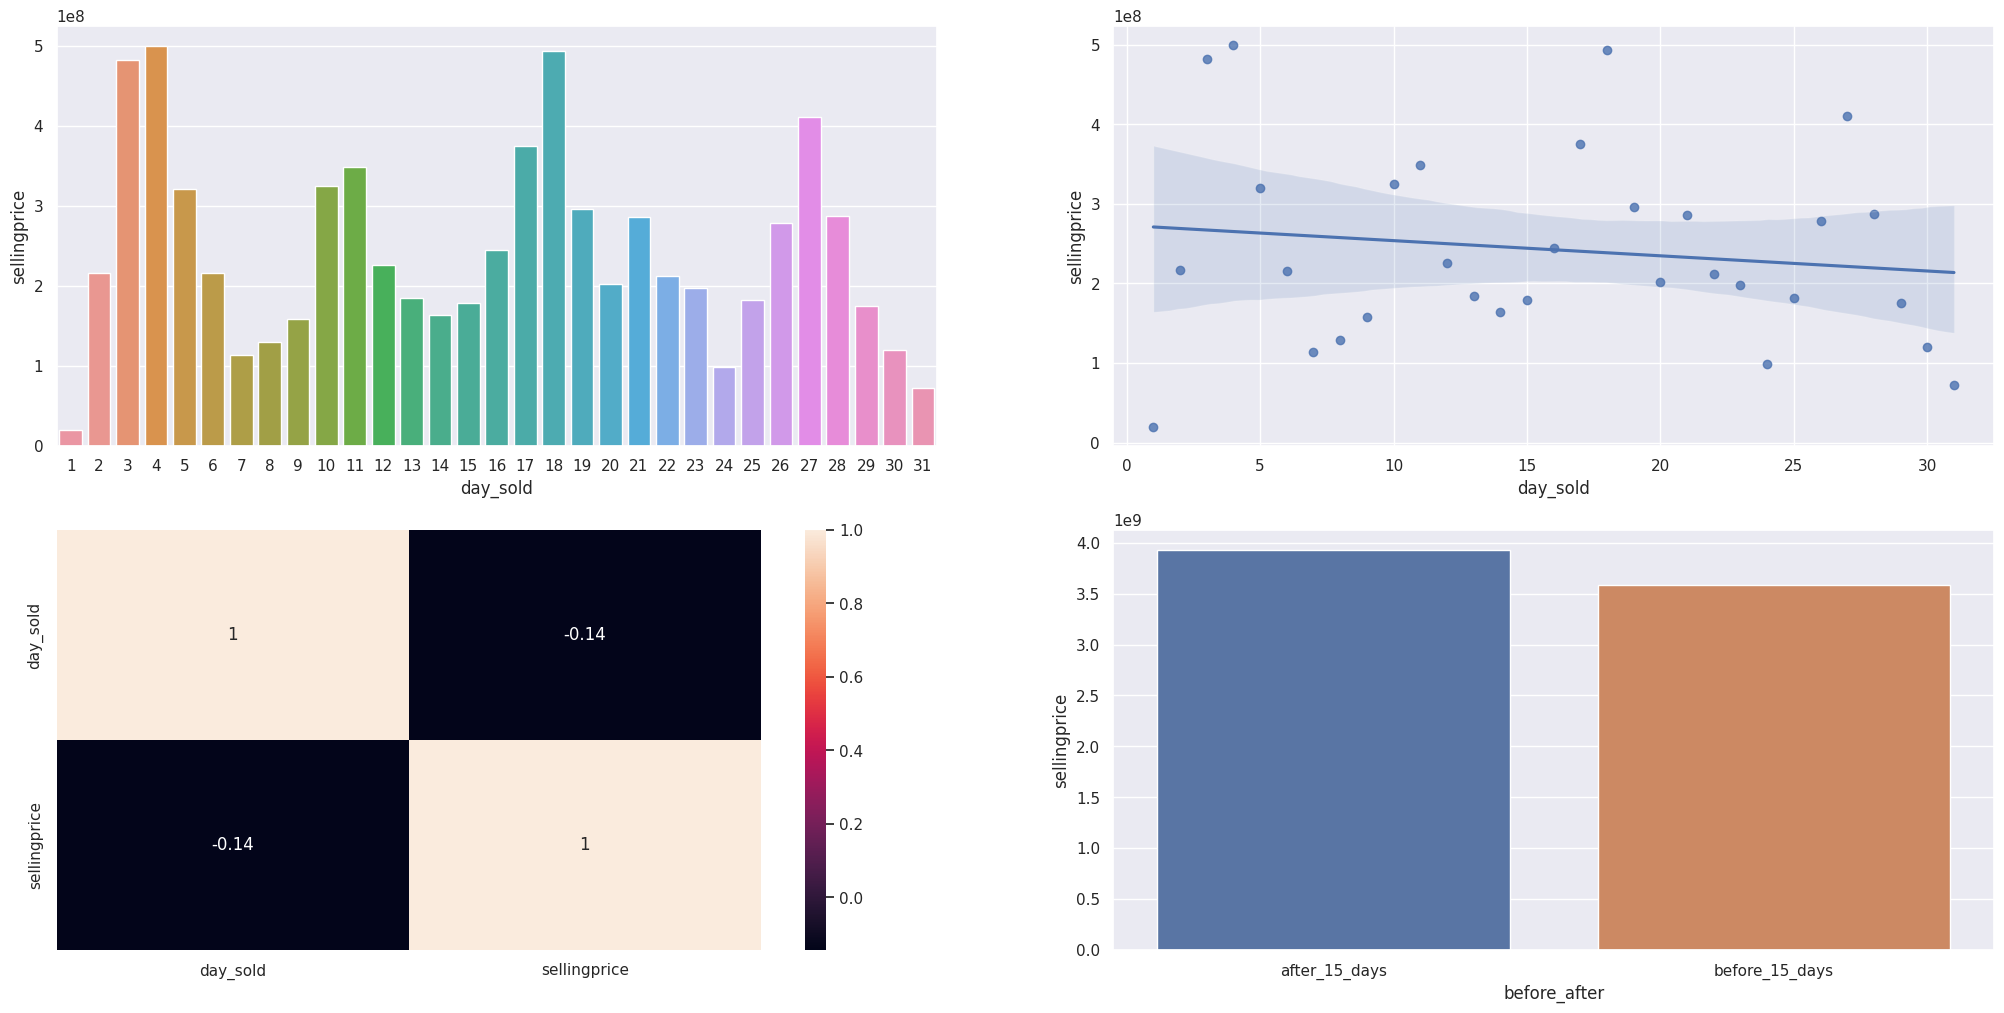

In [45]:
aux2 = df2[['day_sold', 'sellingprice']].groupby('day_sold').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(data=aux2, x='day_sold', y='sellingprice');

plt.subplot(2,2,2)
sns.regplot(data=aux2, x='day_sold', y='sellingprice');

plt.subplot(2,2,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux2['before_after'] = aux2['day_sold'].apply(lambda x: 'before_15_days' if x <= 15 else 'after_15_days')
aux2 = aux2[['before_after', 'sellingprice']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux2, x='before_after', y='sellingprice');

### 8. O Montante do valor em vendas é em média até 20% superior aos finais de semana

_Falso_: As vendas são considerávelmente maiores no meio da semana

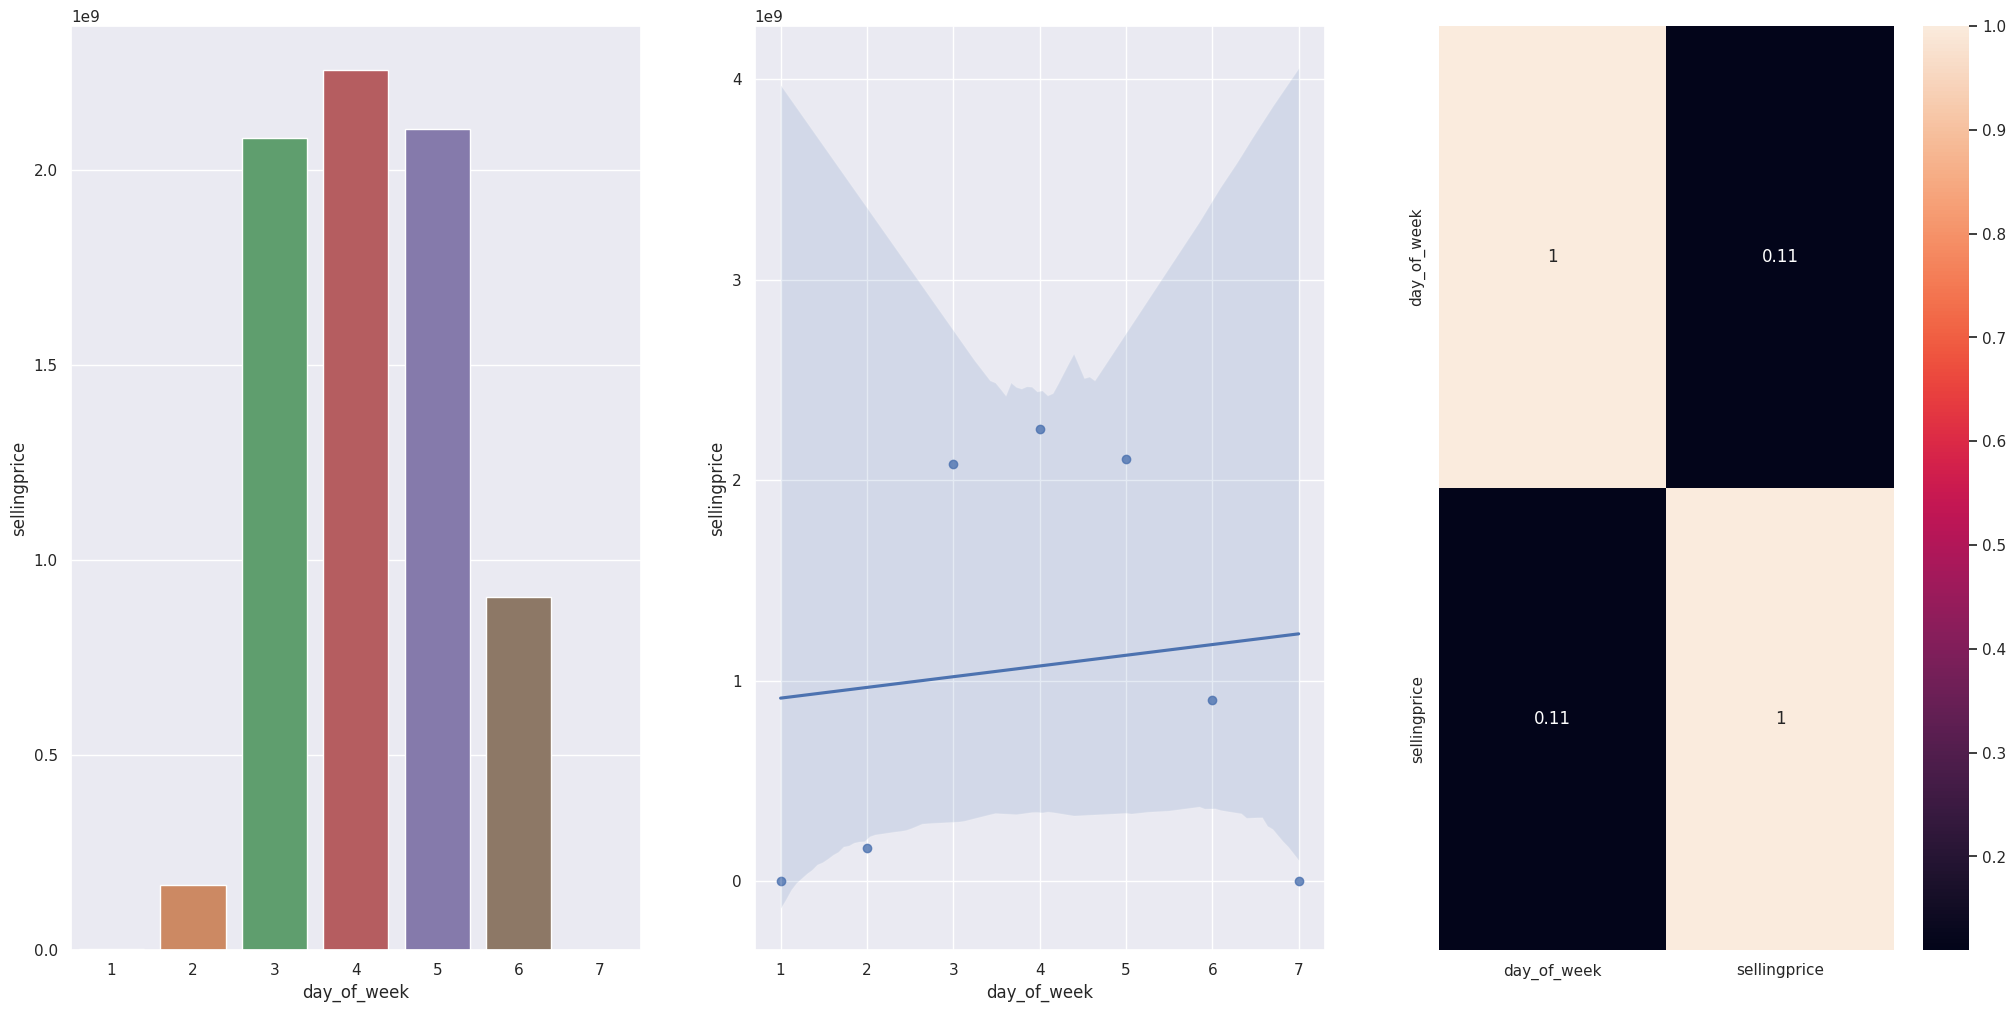

In [46]:
aux2 = df2.copy()
aux2['day_of_week'] = aux2['day_of_week'].apply(lambda x: 1 if x == 'Sun' else
                                                          2 if x == 'Mon' else
                                                          3 if x == 'Tue' else
                                                          4 if x == 'Wed' else
                                                          5 if x == 'Thu' else
                                                          6 if x == 'Fri' else
                                                          7)
aux2 = aux2[['day_of_week', 'sellingprice']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux2, x='day_of_week', y='sellingprice');

plt.subplot(1,3,2)
sns.regplot(data=aux2, x='day_of_week', y='sellingprice');

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

Dessa forma, a EDA nos indica que as seguintes variáveis tem impacto relevante na alteração do preço de venda:

1.  year
2.  make
3.  body
4.  odometer
5.  month_sold
6.  day_of_week

# 3.0 SELEÇÃO DE FEATURES

In [47]:
df3 = df2.copy()

## 3.2 Tratamento dos Dados

### 3.2.1 Váriaveis Numéricas (Robust Scaler)

In [48]:
# Numerical variables
numeric_cols = [cname for cname in df3.columns if df3[cname].dtype in ['int64', 'float64']]
numeric_cols.remove('sellingprice')

# RobustScaler
scaler = RobustScaler()
scaler.fit(df3[numeric_cols])

# Transform the numeric columns
df3[numeric_cols] = scaler.transform(df3[numeric_cols])
df3.head()


vin  year   make                model        trim   body transmission state  condition  odometer  color interior                                  seller  year_sold  month_sold  day_sold day_of_week       mmr  sellingprice
0  5xyktca69fg566472   0.6    Kia              Sorento          LX    SUV    automatic    ca  -1.705882 -0.498341  white    black                 kia motors america  inc       -1.0         2.0  0.000000         Tue  0.732584       21500.0
1  5xyktca69fg561319   0.6    Kia              Sorento          LX    SUV    automatic    ca  -1.705882 -0.602200  white    beige                 kia motors america  inc       -1.0         2.0  0.000000         Tue  0.759551       21500.0
2  wba3c1c51ek116351   0.4    BMW             3 Series  328i SULEV  Sedan    automatic    ca   0.647059 -0.717755   gray    black  financial services remarketing (lease)        0.0        -0.2 -0.071429         Thu  1.757303       30000.0
3  yv1612tb4f1310987   0.6  Volvo                  S60          T5  Sedan    automatic    ca   0.411765 -0.532125  white    black                 volvo na rep/world omni        0.0        -0.2  0.928571         Thu  1.361798       27750.0
4  wba6b2c57ed129731   0.4    BMW  6 Series Gran Coupe        650i  Sedan    automatic    ca   0.529412 -0.698979   gray    black  financial services remarketing (lease)       -1.0         2.0  0.142857         Thu  4.822472       67000.0

### 3.2.2 Variáveis Categóricas (Mean Target Encoding)

In [49]:
#make - Mean Target Encoding
te_make = df3.groupby('make')['sellingprice'].mean()
df3.loc[:, 'make'] = df3['make'].map(te_make)
df3['make'] = df3['make'].astype(np.float64)

#model - Mean Target Encoding
te_model = df3.groupby('model')['sellingprice'].mean()
df3.loc[:, 'model'] = df3['model'].map(te_model)
df3['model'] = df3['model'].astype(np.float64)

#trim - Mean Target Encoding
te_trim = df3.groupby('trim')['sellingprice'].mean()
df3.loc[:, 'trim'] = df3['trim'].map(te_trim)
df3['trim'] = df3['trim'].astype(np.float64)

#body - Mean Target Encoding
te_body = df3.groupby('body')['sellingprice'].mean()
df3.loc[:, 'body'] = df3['body'].map(te_body)
df3['body'] = df3['body'].astype(np.float64)

#transmission - Mean Target Encoding
te_transmission = df3.groupby('transmission')['sellingprice'].mean()
df3.loc[:, 'transmission'] = df3['transmission'].map(te_transmission)
df3['transmission'] = df3['transmission'].astype(np.float64)

#state - Mean Target Encoding
te_state = df3.groupby('state')['sellingprice'].mean()
df3.loc[:, 'state'] = df3['state'].map(te_state)
df3['state'] = df3['state'].astype(np.float64)

#color - Mean Target Encoding
te_color = df3.groupby('color')['sellingprice'].mean()
df3.loc[:, 'color'] = df3['color'].map(te_color)
df3['color'] = df3['color'].astype(np.float64)

#interior - Mean Target Encoding
te_interior = df3.groupby('interior')['sellingprice'].mean()
df3.loc[:, 'interior'] = df3['interior'].map(te_interior)
df3['interior'] = df3['interior'].astype(np.float64)

#seller - Mean Target Encoding
te_seller = df3.groupby('seller')['sellingprice'].mean()
df3.loc[:, 'seller'] = df3['seller'].map(te_seller)
df3['seller'] = df3['seller'].astype(np.float64)

#day_of_week - Mean Target Encoding
te_day_of_week = df3.groupby('day_of_week')['sellingprice'].mean()
df3.loc[:, 'day_of_week'] = df3['day_of_week'].map(te_day_of_week)
df3['day_of_week'] = df3['day_of_week'].astype(np.float64)


In [50]:
df3.head()

vin  year          make         model          trim          body  transmission         state  condition  odometer         color      interior        seller  year_sold  month_sold  day_sold   day_of_week       mmr  sellingprice
0  5xyktca69fg566472   0.6  11808.672918  14643.257923  10289.226055  15905.503680  13779.127879  14543.959338  -1.705882 -0.498341  14868.265497  15724.498769  16122.995733       -1.0         2.0  0.000000  12949.122515  0.732584       21500.0
1  5xyktca69fg561319   0.6  11808.672918  14643.257923  10289.226055  15905.503680  13779.127879  14543.959338  -1.705882 -0.602200  14868.265497  13443.914697  16122.995733       -1.0         2.0  0.000000  12949.122515  0.759551       21500.0
2  wba3c1c51ek116351   0.4  21441.895748  16809.633106  29540.000000  11593.969478  13779.127879  14543.959338   0.647059 -0.717755  13983.754463  15724.498769  28580.446148        0.0        -0.2 -0.071429  13959.775069  1.757303       30000.0
3  yv1612tb4f1310987   0.6  11463.952482  13766.587164  16348.906742  11593.969478  13779.127879  14543.959338   0.411765 -0.532125  14868.265497  15724.498769  25907.214429        0.0        -0.2  0.928571  13959.775069  1.361798       27750.0
4  wba6b2c57ed129731   0.4  21441.895748  55162.990741  36178.477223  11593.969478  13779.127879  14543.959338   0.529412 -0.698979  13983.754463  15724.498769  28580.446148       -1.0         2.0  0.142857  13959.775069  4.822472       67000.0

##  3.1 Separação treino-teste

In [51]:
X_split = df3.drop(['vin', 'sellingprice'], axis = 1)
y_split = df3['sellingprice'].copy()

X_train, X_validation, y_train, y_validation = train_test_split(X_split, y_split, test_size=0.2, random_state = 32)

df3 = pd.concat([X_train, y_train], axis=1)
df3 = df3.reset_index(drop=True)

In [52]:
training_data, testing_data = X_train, X_validation

print(f'No. of training examples:{training_data.shape[0]}')
print(f'No. of testing examples:{testing_data.shape[0]}')

No. of training examples:438816
No. of testing examples:109704


## 3.3 Feature Selection(com Random Forest)

In [53]:
X_train_n = X_train
y_train_n = y_train.values

#Define Extra Trees Classifier
rf = RandomForestRegressor(n_estimators=100, random_state=32, n_jobs=-1)
rf.fit(X_train_n, y_train_n)

RandomForestRegressor(n_jobs=-1, random_state=32)

Feature Ranking:
        feature  importance
0           mmr    0.968745
0     condition    0.008026
0      odometer    0.004729
0        seller    0.003334
0         model    0.002086
0      day_sold    0.001976
0          trim    0.001860
0         state    0.001678
0          year    0.001267
0         color    0.001238
0          body    0.001226
0          make    0.001131
0    month_sold    0.000872
0   day_of_week    0.000807
0      interior    0.000782
0  transmission    0.000130
0     year_sold    0.000112


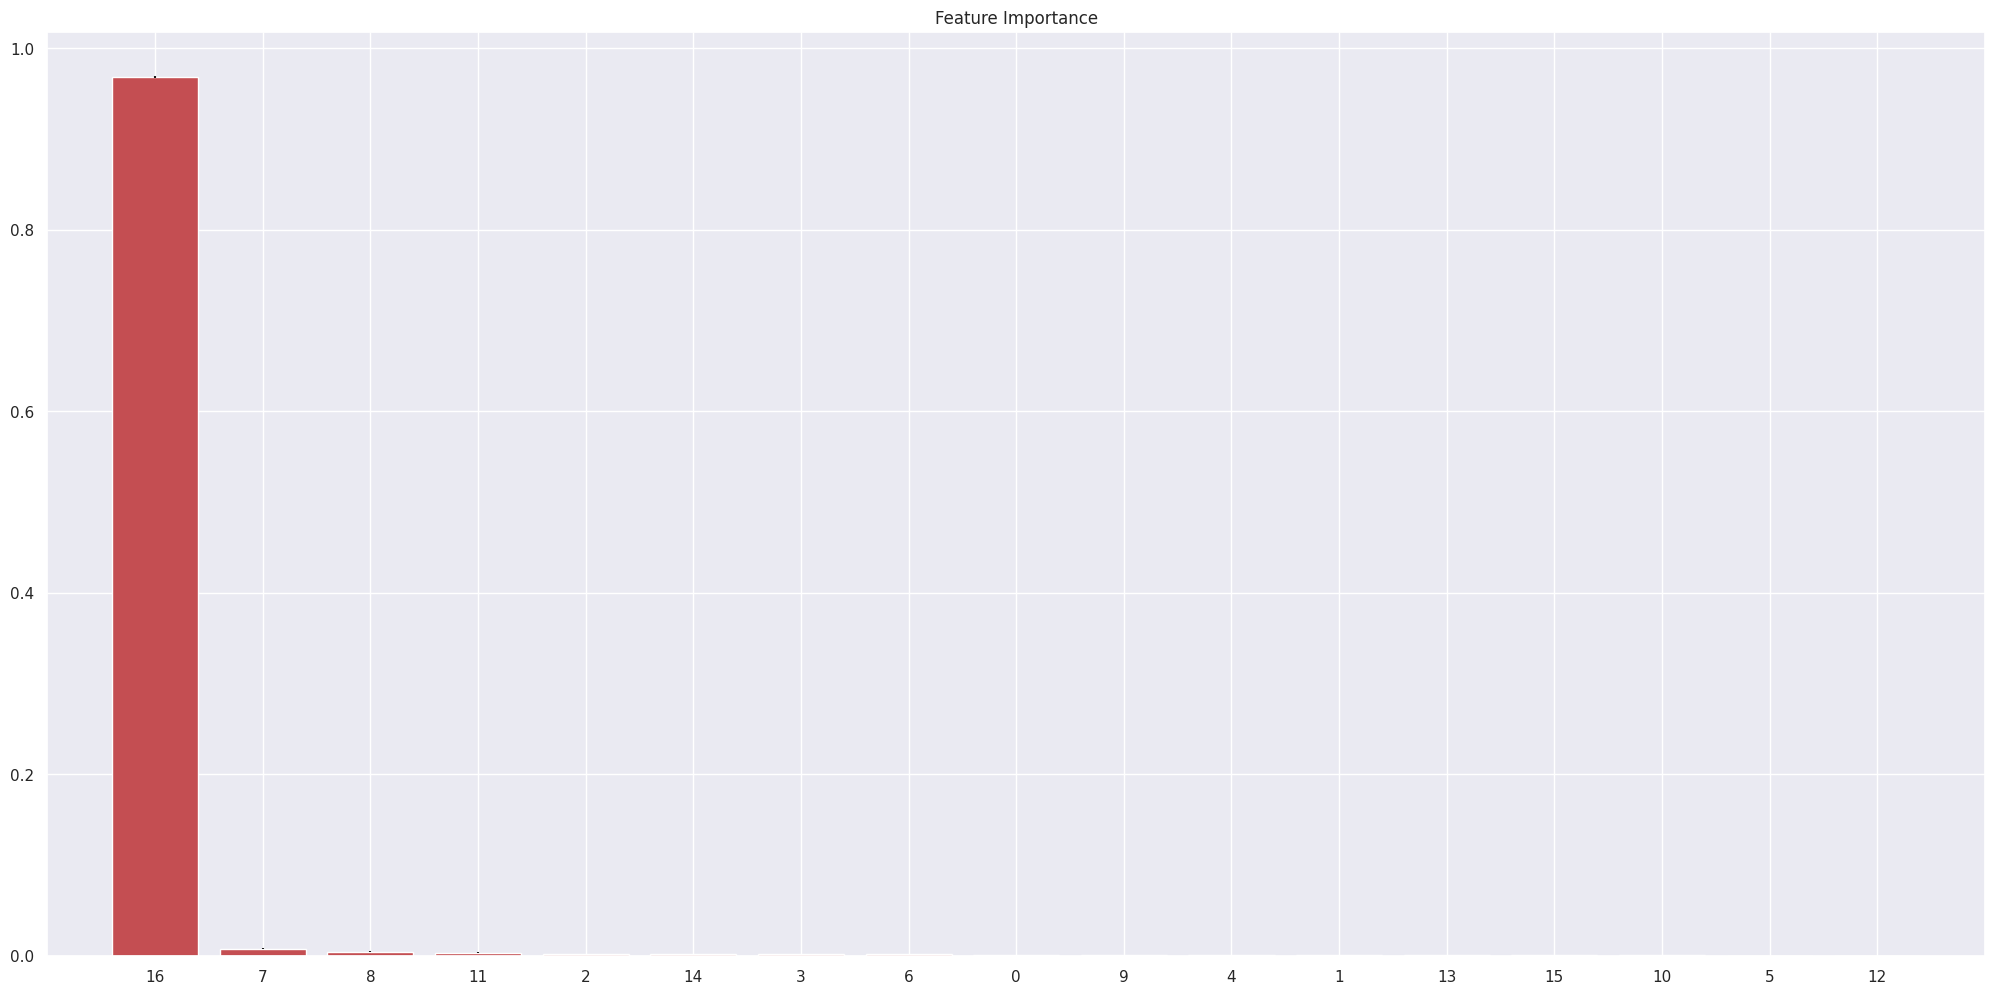

In [54]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Print the Feature Ranking
print('Feature Ranking:')
df = pd.DataFrame()
for i, j in zip(X_train_n, rf.feature_importances_):
    aux_imp = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux_imp], axis=0)

print(df.sort_values('importance', ascending=False))

#Plot the Impurity based feature importance target
plt.figure()
plt.title('Feature Importance')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

Dessa forma, Através da análise feita via floresta de Regressão, temos como features mais influentes do modelo:

1. mmr
2. condition
3. odometer
4. seller
5. model
6. day_sold
7. trim
8. state
9. year
10. color
11. body
12. make
13. month_sold

**NOTA**: A Feature 'mmr', por representar originalmente um valor de referência usado para negociação final de venda, possui valores próximos observados ao da nossa váriavel alvo 'sellingprice'.
Tal proximidade de valores, reafirmada pela disparidade na importância da feature em comparação as demais quando da seleção para formação dos melhores 'ramos' das arvores da random forest podem ser um indicativo de **vazamento de dados**.

# 4.0 MODELAGEM

In [55]:
df4 = df3.copy()

In [56]:
cols_selected = ['year', 'make', 'model', 'trim', 'body', 'state',
                 'condition', 'odometer', 'color', 'seller',
                 'month_sold', 'day_sold', 'mmr']

X_train = df4[cols_selected]
X_validation = X_validation[cols_selected]

##  4.1 Dummy Model

In [57]:
dummy = DummyRegressor().fit(X_train, y_train)

#Model Prediction
yhat_dummy = dummy.predict(X_validation)

#Model Performance
dummy_result = ml_error('Linear Regression Model', y_validation, yhat_dummy)
dummy_result


Model Name          MAE     MAPE         RMSE
0  Linear Regression Model  7116.970313  1.76835  9687.277287

##  4.2 XGBoost Model

In [58]:
#model
model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror',
                              n_estimators=1000,
                              eta= 0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9).fit(X_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(X_validation)

#performance
xgb_result = ml_error('XGBoost Regressor Model', y_validation, yhat_xgb)
xgb_result

Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor Model  882.964476  0.121661  1499.754625

In [59]:
xgb_result_cv = cross_validation('XGBoost Regressor', model_xgb, X_train, y_train)
xgb_result_cv

Fold k-0
Fold k-1
Fold k-2
Fold k-3
Fold k-4


Model Name           MAE_CV        MAPE_CV            RMSE_CV
0  XGBoost Regressor  886.06 +/- 4.98  0.19 +/- 0.09  1563.66 +/- 67.23

##  4.3 Random Forest Regressor Model

In [60]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

#prediction
yhat_rf = rf.predict(X_validation)

#performance
rf_result = ml_error('Random Forest Regressor Model', y_validation, yhat_rf)
rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor Model  919.120706  0.129468  1459.777172

In [61]:
rf_result_cv = cross_validation('Random Forest Regressor Model', rf, X_train, y_train)
rf_result_cv

Fold k-0
Fold k-1
Fold k-2
Fold k-3
Fold k-4


Model Name           MAE_CV       MAPE_CV            RMSE_CV
0  Random Forest Regressor Model  926.93 +/- 5.79  0.2 +/- 0.09  1537.38 +/- 63.81

## 4.4 Comparativo de Resultados

In [62]:
modeling_result = pd.concat([dummy_result, xgb_result, rf_result])
modeling_result

Model Name          MAE      MAPE         RMSE
0        Linear Regression Model  7116.970313  1.768350  9687.277287
0        XGBoost Regressor Model   882.964476  0.121661  1499.754625
0  Random Forest Regressor Model   919.120706  0.129468  1459.777172

In [63]:
modeling_result_cv = pd.concat([ xgb_result_cv, rf_result_cv])
modeling_result_cv

Model Name           MAE_CV        MAPE_CV            RMSE_CV
0              XGBoost Regressor  886.06 +/- 4.98  0.19 +/- 0.09  1563.66 +/- 67.23
0  Random Forest Regressor Model  926.93 +/- 5.79   0.2 +/- 0.09  1537.38 +/- 63.81